Задание 1. А/В-тестирование.

Импортирую необходимые библиотеки:

In [1]:
import pandas as pd

import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns

In [12]:
import os

folder_path = r'/mnt/HC_Volume_18315164/home-jupyter/jupyter-enzhe-sultanova-bh-bab0f/My_Folder/Final/'

# Чтение файлов
groups = pd.read_csv(os.path.join(folder_path, 'groups.csv'), encoding='Windows-1251', sep=';')
groups_add = pd.read_csv(os.path.join(folder_path, 'group_add.csv'), encoding='Windows-1251', sep=',')
active_studs = pd.read_csv(os.path.join(folder_path, 'active_studs.csv'), encoding='Windows-1251', sep=';')
checks = pd.read_csv(os.path.join(folder_path, 'checks.csv'), encoding='Windows-1251', sep=';')

In [13]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [14]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [15]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [16]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [17]:
groups_all = pd.concat([groups, groups_add], ignore_index=True)

In [18]:
groups_all.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [19]:
# доля пользователей по тестовым группам:

ab_distribution = groups_all['grp'].value_counts(normalize=True)

ab_distribution

B    0.80298
A    0.19702
Name: grp, dtype: float64

In [20]:
# распределение по количеству:

ab_cnt = groups_all['grp'].value_counts()

ab_cnt

B    59883
A    14693
Name: grp, dtype: int64

In [21]:
groups_all = groups_all.rename(columns={'id':'student_id'})

In [22]:
# формирую датафрейм только с активными пользователями:

active_groups = pd.merge(groups_all, active_studs, on='student_id', how='inner')

In [23]:
# проверяю есть ли в checks платежи от неактивных пользователей:

#все активные пользователи
active = set(active_studs['student_id'])
#все, кто совершил платеж
paying = set(checks['student_id'])

paying_not_active = paying - active
print(f"Количество платящих НЕактивных: {len(paying_not_active)}")

Количество платящих НЕактивных: 149


In [24]:
# добавляю инфо об оплатах только для активных пользователей:

active_groups_all = pd.merge(active_groups, checks, on='student_id', how='left')

In [25]:
active_groups_all = active_groups_all.dropna()  #удаляю неактивных (строки с пустыми rev)

In [26]:
# проверяю число активных в группах:

active_groups_all.groupby('grp', as_index=False).student_id.count()

,grp,student_id
0,A,78
1,B,314


Распределение неравномерное. Размер целевой группы (В) больше контрольной (А) в ~4 раза.

Формулирую гипотезы:

    Н0 (нулевая) - новая механика оплаты услуг на сайте не повлияла на поведение пользователей, различия в показателях статистически не значимы.

    Н1 (альтернативная) - новая механика оплаты услуг повлияла на поведение пользователей, различия статистически значимы.

Определяю подходящие для анализа метрики:

    Средний чек пользователя - метрика покажет, на какую сумму пользователь готов делать покупку

    Конверсия в оплату - метрика покажет, изменилась ли доля пользователей, совершивших хотя бы одну оплату

    Выручка - метрика покажет, есть ли изменения в общей выручке на группу после изменения механики оплаты (но из-за неравномерного распределения пользователей по группам, данную метрику не стоит рассматривать основной)

In [27]:
# разделяю данные по группам

group_a = active_groups_all[active_groups_all['grp'] == 'A']

group_b = active_groups_all[active_groups_all['grp'] == 'B']

all_a = len(active_groups[active_groups['grp'] == 'A'])

all_b = len(active_groups[active_groups['grp'] == 'B'])

In [28]:
# определяю средний чек в тестовых группах:

avg_check_a = round(group_a['rev'].mean(), 1)

avg_check_b = round(group_b['rev'].mean(), 1)

In [29]:
# конверсия в оплату:

paid_a = group_a['student_id'].nunique()

paid_b = group_b['student_id'].nunique()

cr_a = round(paid_a / all_a * 100, 1)

cr_b = round(paid_b / all_b * 100, 1)

In [30]:
# общая выручка в тестовых группах:

revenue_a = round(group_a['rev'].sum(), 1)

revenue_b = round(group_b['rev'].sum(), 1)

In [31]:
print('Группа А:', 'средний чек =', avg_check_a, ', конверсия =', cr_a, ', общая выручка =', revenue_a)

print('Группа В:', 'средний чек =', avg_check_b, ', конверсия =', cr_b, ', общая выручка =', revenue_b)

Группа А: средний чек = 933.6 , конверсия = 5.1 , общая выручка = 72820.0
Группа В: средний чек = 1257.9 , конверсия = 4.6 , общая выручка = 394974.0


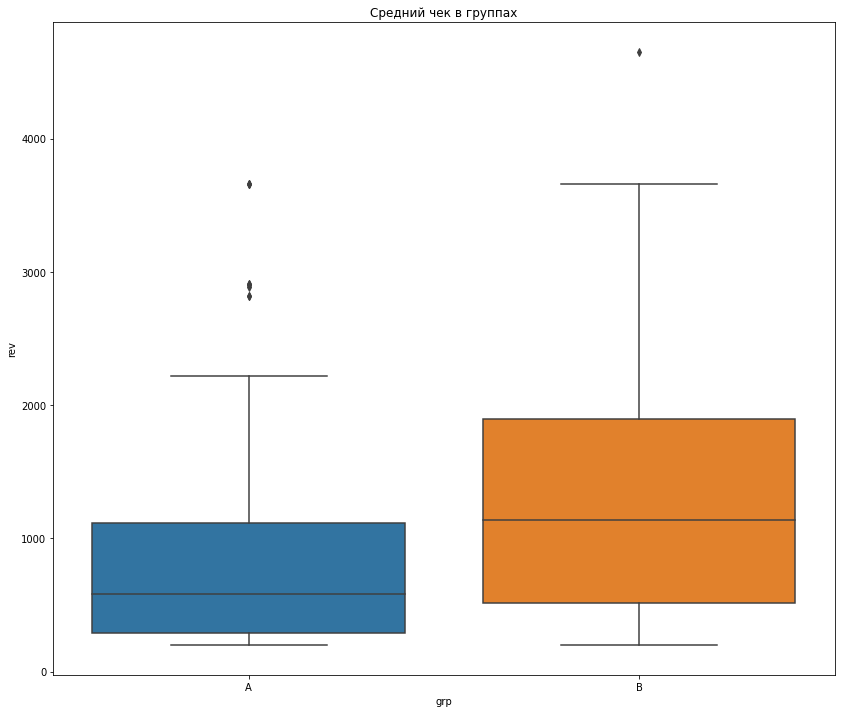

In [32]:
# визуализация:

plt.figure(figsize=(14, 12))

sns.boxplot(data=active_groups_all, x="grp", y="rev")

plt.title("Средний чек в группах")

plt.show()

Таким образом, сравнив метрики в тестовых группах видно, что новая механика оплаты услуг не дала прироста конверсии 
(разница −0.5%), несмотря на то, что средний чек группы В выше.

Проверка статистической значимости.

Для сравнения средний значений показателя 'rev' в целевой и контрольной группах был выбран t-test. Перед проведением теста проверю допущения:

In [33]:
# нормальность распределения (тест Шапиро-Уилка):

print(stats.shapiro(group_a['rev']))

print(stats.shapiro(group_b['rev']))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


Результаты теста Шапиро-Уилка однозначно показывают, что распределения НЕ являются нормальными в обеих группах. Но считается, что для малых размеров выборок (обычно < 30) нормальность данных достаточно критична для t-теста. Однако для таких масштабов, с которыми работает индустрия, это не особо важно: основой t-теста является ЦПТ, а она работает даже с ненормальными ГС. В данном исследовании выборки в группах размером > 30, поэтому результатами нормальности можно пренебречь.

In [34]:
# проверяю равенство дисперсий с помощью теста Левена

levene_stat, levene_p = stats.levene(group_a['rev'], group_b['rev'])

print(f"\nP-значение = {levene_p:.4f}")

if levene_p < 0.05:

    equal_var_flag = False

    print("Значимое различие (t-тест с equal_var=False)")

else:

    equal_var_flag = True

    print("Дисперсии не различаются (t-тест с equal_var=True)")


P-значение = 0.0803
Дисперсии не различаются (t-тест с equal_var=True)


In [35]:
# использую t-test для среднего чека:

B = group_b[group_b['rev'] > 0]['rev']

A = group_a[group_a['rev'] > 0]['rev']

t_stat, p_value = stats.ttest_ind(A, B, equal_var=True)

print(f"p-value для разницы средних чеков: {p_value:.4f}")

if p_value < 0.05:

    print("Разница статистически значима (p < 0.05)")

else:

    print("Разница статистически НЕ значима (p >= 0.05)")

p-value для разницы средних чеков: 0.0019
Разница статистически значима (p < 0.05)


 Несмотря на то, что группа B демонстрирует более низкую конверсию, средний чек пользователя в этой группе 
 превышает показатель группы A (+324,3), т.е. те кто платил - платили больше, и эта разница оказалась 
 статистически значима.

In [36]:
# использую Z-статистику для конверсии - тест для сравнения двух пропорций при больших объемах выборок:

from statsmodels.stats.proportion import proportions_ztest

# исходныe данныe:
# cr_a = 5.1
# cr_b = 4.6
# all_a = 1538
# all_b = 6803

p_a = cr_a/100 * all_a
p_b = cr_b/100 * all_b

count = np.array([p_a, p_b])
nobs = np.array([all_a, all_b])

stat, pval = proportions_ztest(count, nobs)

print(f"Z-статистика: {stat:.4f}")
print(f"P-значение: {pval:.4f}")

if pval < 0.05:
    print("Разница статистически значима (p < 0.05)")
else:
    print("Разница не значима (p >= 0.05)")

Z-статистика: 0.8374
P-значение: 0.4024
Разница не значима (p >= 0.05)


Несмотря на разницу конверсий в 0.5%, она статистически не значима, возможно, из-за относительно малого размера группы A.

>Вывод на основе статистических результатов:

>>Новая механика оплаты услуг не повлияла на долю оплачивающих пользователей, но те, кто совершил покупку, стали тратить больше. Это указывает на то, что изменения повлияли на поведение платящей аудитории, но не привлекли новых покупателей.

>>Стоит ли запускать новую механику на всех пользователей? Нельзя однозначно рекомендовать. Однако, из-за увеличения среднего чека следует, что новая механика увеличила общую выручку, и возможно запуск будет оправдан. Но перед тем, как принимать решение, необходимо уточнить у команды, возможно есть какие-то ошибки в данных.

